# Visión computacional
## Tarea: Filtrado

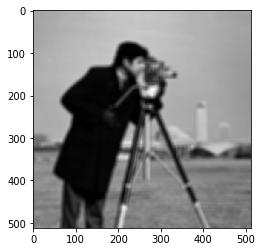

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import data
from skimage.util import img_as_float

Img = data.camera()
Imf = img_as_float(Img)     #Convierte de uint8 a float
H = np.ones([11,11])*1/11.0 #Kernel de convolución de 11x11 pixeles
Ip = ndimage.convolve(Imf,H)

plt.imshow(Ip,cmap='gray')
plt.show()

## Kernel Gaussiano

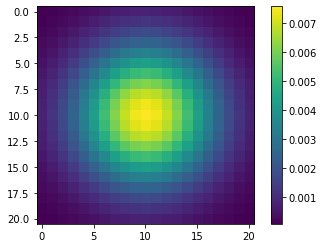

In [7]:
import scipy.stats as st

def gkern(kernlen=21, nsig=5):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

Kg = gkern(21,3)
plt.imshow(Kg)
plt.colorbar()
plt.show()

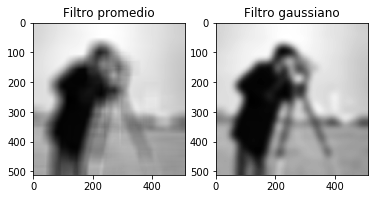

In [8]:
Imf = img_as_float(Img)      #Convierte de uint8 a float
H = np.ones([51,51])*1/51.0  #Kernel de promedio móvil
Ip = ndimage.convolve(Imf,H)

kernel = gkern(51,nsig=3) #Kernel gausiano 51x51 y sigma = 3

Im = data.camera()
Ig = ndimage.convolve(Im,kernel)

plt.subplot(121),plt.imshow(Ip,cmap='gray'), plt.title('Filtro promedio')
plt.subplot(122),plt.imshow(Ig,cmap='gray'), plt.title('Filtro gaussiano')
plt.show()

## Transformada de Fourier 2D

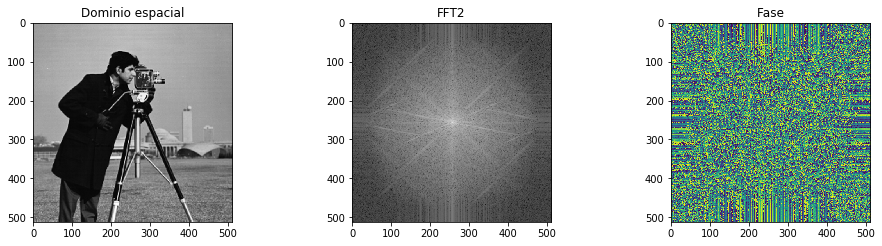

In [52]:
from scipy.fftpack import fft2,fftshift,ifft2

FImg = fft2(Imf)
FI_centrada = fftshift(FImg) #Esta función corrige el array retornado por fft

plt.subplot(131), plt.imshow(Imf,cmap='gray'), plt.title("Dominio espacial")
PI = np.angle(FI_centrada)
plt.subplot(132), plt.imshow(np.log(np.abs(FI_centrada)**2),cmap='gray')
plt.title("FFT2")
plt.subplot(133), plt.imshow(PI), plt.title("Fase")
plt.subplots_adjust(wspace = 0.6)
plt.rcParams["figure.figsize"]=8,5
plt.show()

## Filtrado en dominio de la frecuencia
### Filtrado pasa-bajas con máscara circular 

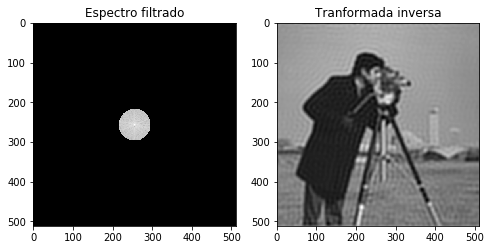

In [76]:
from scipy.fftpack import ifftshift
from skimage import draw

#Generar mascara circular pasa bajas
m,n = FI_centrada.shape
LPFm = np.zeros([m,n])
Cx,Cy = draw.circle(np.ceil(m/2.),np.ceil(n/2.),40)
LPFm[Cx,Cy] = 1

#Filtrado
FI_filtrada = FI_centrada*LPFm


#Tranformada inversa
FI = ifftshift(FI_filtrada)
Img_Filtrada = np.real(ifft2(FI))

ep = 1e-8 # Para evitar el warning de la función log
plt.subplot(121),plt.imshow(np.log(np.abs(FI_filtrada+ep)**2),cmap='gray'), plt.title("Espectro filtrado")
plt.subplot(122),plt.imshow(Img_Filtrada,cmap='gray'),plt.title("Tranformada inversa")
plt.show()

### Filtrado pasa-altas con mascara circular

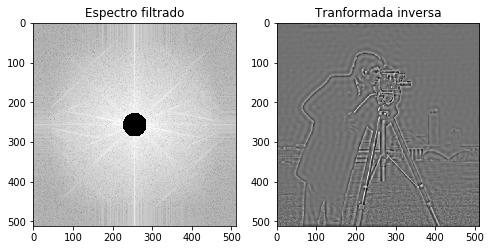

In [80]:
#Generar mascara circular pasa altas
m,n = FI_centrada.shape
HPFm = np.ones([m,n])
Cx,Cy = draw.circle(np.ceil(m/2.),np.ceil(n/2.),30)
HPFm[Cx,Cy] = 0

#Filtrado
FI_filtrada = FI_centrada*HPFm
ep = 1e-8 # Para evitar el warning de la función log

#Tranformada inversa
FI = ifftshift(FI_filtrada)
Img_Filtrada = np.real(ifft2(FI))

plt.subplot(121),plt.imshow(np.log(np.abs(FI_filtrada+ep)**2),cmap='gray'), plt.title("Espectro filtrado")
plt.subplot(122),plt.imshow(Img_Filtrada,cmap='gray'),plt.title("Tranformada inversa")
plt.show()

### Obtención del kernel convolucional para detección de bordes

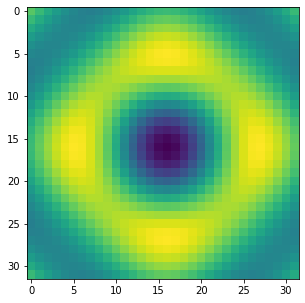

In [102]:
HPF = ifftshift(HPFm+0j) #Reajuste a formato estandar
H = np.real(ifft2(HPF))  #Transformada inversa

#Recorte de kernel
m,n = H.shape
fr = 32
Hk = H[int(m/2-m/fr):int(m/2+m*1/fr),int(n/2-n/fr):int(n/2+n*1/fr)]

plt.imshow(Hk)
plt.show()

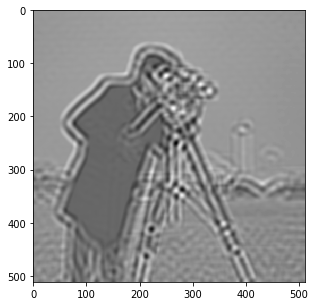

In [101]:
#Prueba del kernel

Ibordes = ndimage.convolve(Imf,Hk)
plt.imshow(Ibordes,cmap='gray')
plt.show()

### Intercambio de fases

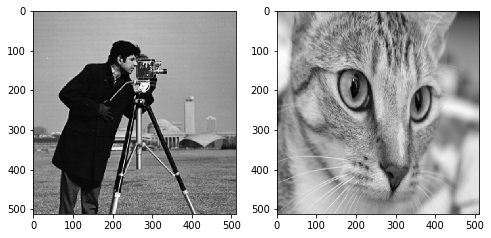

In [107]:
from skimage import transform, color
I1 = data.camera()
I2 = color.rgb2gray(data.chelsea())

# Cambio de forma para ajustar tamaños
m,n = I1.shape
I2 = transform.resize(I2,(m,n))

plt.subplot(121), plt.imshow(I1,cmap='gray')
plt.subplot(122), plt.imshow(I2,cmap='gray')
plt.show()

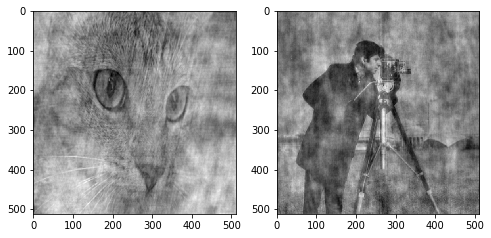

In [112]:
#Tranformadas
FI1 = fft2(I1)
FI2 = fft2(I2)

#Fases
PI1 = np.angle(FI1)
PI2 = np.angle(FI2)

#Modulos
RI1 = np.abs(FI1)
RI2 = np.abs(FI2)

#Intercambio de fases
FI1C = RI1*(np.cos(PI2)+1j*np.sin(PI2))
FI2C = RI2*(np.cos(PI1)+1j*np.sin(PI1))

#Transformada inversa
I1C = np.real(ifft2(FI1C))
I2C = np.real(ifft2(FI2C))

#Gráficas
plt.subplot(121),plt.imshow(I1C,cmap='gray')
plt.subplot(122),plt.imshow(I2C,cmap='gray')
plt.show()